# Geodatenanalyse 2: Termin 10 - Bayesische Hyperparameteroptimierung und Ensemble-Modellierung

Ziel der Übung: Für das LSTM Modell aus Termin 8 zur Grundwasserstandsvorhersage sollen die Länge der Inputsequenz sowie der Anzahl der Units im LSTM Layer optimiert werden. Weiterhin minimieren wir den Einfluss der Modellinitialisierung durch ein Ensemble basierend auf definierten *random number seeds* 

Zunächst nutzen wir viele Zellen des Notebooks aus Termin 8, der Einfachheit halber werden diese hier etwas zusammengefasst.

In [38]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### set random seed
# Um ein reproduzierbares Ergebnis zu erhalten definieren wir zunächst die Startpunkte (seeds) der Zufallszahlengeneratoren von numpy und tensorflow:

#set random seed for reproducability
from numpy.random import seed
seed(347824) # this is a randomly chosen number

from tensorflow import random
random.set_seed(63494) # this is also a randomly chosen number

print("seeds are set")

# ### load data
# Die (wöchentlich) Grundwasserdaten befinden sich in der Datei: **GW-Data.csv**  
# Die meteorologischen Inputdaten in der Datei: **Climate-Data.csv**
# Wir laden die Dateien als pandas Dataframe mit einem datetimeindex ein und führen beide Dateien zusammen.

GWData = pd.read_csv('./GW-Data.csv',
                     parse_dates=['Date'], # hiermit werden Zeitangaben als Datum erkannt
                     index_col=0, # definiert welche Spalte der gelesenen Daten als Index für den DataFrame dienen soll
                     dayfirst = True, # definiert das Datumsformat 
                     decimal = '.', sep=',') # Angaben welche Trennzeichen in der Datei verwendet werden

ClimateData = pd.read_csv('Climate-Data.csv', 
                          parse_dates=['Date'],index_col=0,dayfirst = True,
                          decimal = '.', sep=',')

# Beide DataFrames zusammenführen
data = pd.merge(GWData, ClimateData, how='inner', left_index = True, right_index = True) # beide DataFrames zusammenführen


#Dies mal schauen wir uns die Daten nicht nochmal an, da wir sie bereits kennen: 
#Wir nutzen diesmal alle Inputparameter (inklusiv rH und Tsin).

# import matplotlib.pyplot as plt
# #plot GWL data
# plt.figure(figsize=(20,6))
# plt.plot(data.index,data['GWL'], 'k', label ="GWL", linewidth = 1.7)
# plt.title("GWL Data", size=17,fontweight = 'bold')
# plt.ylabel('GWL [m asl]', size=15)
# plt.xlabel('Date',size=15)
# plt.legend(fontsize=15,loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
# plt.tight_layout()
# plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

# #inspect the data
# data.head()



### we are using sequence models! (still...)
#Wir nutzen die Funktion vom letzten Termin um die Daten zu Sequenzieren:

def make_sequences(data, n_steps_in):
#     """
#     data: numpy array with target (Y) in first column and model inputs in following columns
#     n_steps_in: number that defines the sequence length
    
#     Output:
#     X: sequenced model input data
#     Y: sequenced model target data
    
#     function modified after: machinelearningmastery.com
#     """
    
    #sequence the data
    X, Y = list(), list()
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # find the end of this pattern
        end_idx = i + n_steps_in
        # check if we are beyond the dataset
        if end_idx >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x = data[i:end_idx, 1:]
        seq_y = data[end_idx, 0]
        X.append(seq_x)
        Y.append(seq_y)
        
    return np.array(X), np.array(Y)


seeds are set


### split data (diesmal in 4! Teile)

Bevor wir die Daten in Sequenzen umwandeln, müssen wir aber zunächst noch den bekannten Train-Test-Split durchführen und die Daten anschließend skalieren. Wichtig, KEIN shuffling!

Da wir eine Optimierungsfunktion nutzen und data leakage ins testset vermeiden möchten, brauchen wir diesmal 4 Teile unserer Daten.
  
**Training, Early Stopping (Validation), Optimierungs und Testing**  

Wir nutzen folgende Aufeilung:
* Test: >= 2012  
* Optimierung: 2011  
* Early Stopping: 2010  
* Training: < 2010  

In [39]:
val_startdate = pd.to_datetime('01012010', format='%d%m%Y')
print("Start Stopset")
print(val_startdate)

opt_startdate = pd.to_datetime('01012011', format='%d%m%Y')
print("\nStart Optset") #\n steht für einen Zeilenumbruch
print(opt_startdate)

test_startdate = pd.to_datetime('01012012', format='%d%m%Y')
print("\nStart Testset") #\n steht für einen Zeilenumbruch
print(test_startdate)

#Hier teilen wir die Daten, lassen sie aber noch nicht überlappen(!), dies ist von n_steps_in abhängig, welches wir noch nicht definiert haben
TrainingData = data[(data.index < val_startdate)] 
StopData = data[(data.index >= val_startdate) & (data.index < opt_startdate)]
OptData = data[(data.index >= opt_startdate) & (data.index < test_startdate)]
TestData = data[(data.index >= test_startdate)] 

Start Stopset
2010-01-01 00:00:00

Start Optset
2011-01-01 00:00:00

Start Testset
2012-01-01 00:00:00


### Bayes. Optimierung: Ab hier wird es etwas anders...   
Die Bayesische Optimierung kann nur auf eine Funktion angewendet werden. Wie bereits angesprochen möchten wir *n_steps_in* optimieren. Alles was nach der Festlegung dieses Parameters erst durchgeführt werden kann (z.B. die Überlappung der der Daten-Sets) muss also in diese Funktion reingeschrieben werden. 

EIne solche Funktion sieht vereinfacht so aus:


    def bayesopt_function(x,y,...): 

        hier [CODE] werden die Daten geteilt, skaliert, das Modell aufgebaut, trainiert und evaluiert
    
        return -MSE
    

Die Funktion nimt verschiedene Inputparameter, baut dann das Modell (inkl. aller dafür notwendigen Schritte) und gibt uns den negativen MSE zurück, den wir maximieren möchten (also den Fehler(MSE) minimieren).


In [40]:
def bayesoptfunction(n_steps_in,n): 
    
    #zunächst müssen wir sicherstellen, dass n_steps_in Ganzzahlig ist. 
    #Der Optimierungsalgorithmus gibt immer Float zahlen aus, wir wandeln diese in einen integer um:
    
    n_steps_in = int(n_steps_in)
    n = int(n)
    
    
    #Nun folgende die altbekanten Schritte wie auch in Termin 8
    
    # extend with overlap to be able to fill sequence later                                              
    StopData_ext = pd.concat([TrainingData.iloc[-n_steps_in:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
    OptData_ext = pd.concat([StopData.iloc[-n_steps_in:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
    #TestData_ext = pd.concat([OptData.iloc[-n_steps_in:], TestData], axis=0) #takes last steps of OptData and combines it with TestData
    #die Testdaten werden hier in dieser Funktion nicht benötigt.
    
    #create scalers and scale (normalize: *_n) data:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(TrainingData)

    scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl.fit(pd.DataFrame(TrainingData['GWL']))

    TrainingData_n = scaler.transform(TrainingData)
    StopData_ext_n = scaler.transform(StopData_ext)
    OptData_ext_n = scaler.transform(OptData_ext)
    
    #Daten in Sequenzen umwandeln:
    X_train,Y_train = make_sequences(np.asarray(TrainingData_n), n_steps_in)
    X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), n_steps_in)
    X_opt,Y_opt = make_sequences(np.asarray(OptData_ext_n), n_steps_in)
    
    #Model bauen und trainieren:

    #set seed
    ini=0
    seed(ini+872527)
    tf.random.set_seed(ini+87747)
    
    #build model
    inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))#Define Input Shape
    lstm = tf.keras.layers.LSTM(n)(inp)#add LSTM Layer
    lstm = tf.keras.layers.Dropout(0.1)(lstm) # Dropout layer gegen overfitting
    lstm = tf.keras.layers.Dense(30, activation='relu')(lstm)#add a dense layer
    output1 = tf.keras.layers.Dense(1, activation='linear')(lstm) # output neuron to get meaningful output values
    model = tf.keras.Model(inputs=inp, outputs=output1)#tie together

    #define optimizer
    adamoptimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

    #compile the model
    model.compile(loss='mse', optimizer=adamoptimizer, metrics=['mse'])

    #define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

    #train the model
    history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                        batch_size=32, callbacks=[es])

    #plot training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.title('Loss')
    plt.show()
    
    
    #Modell testen mit X_opt
    sim = model.predict(X_opt)

    #rescale simulated and observed values
    sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
    obs = scaler_gwl.inverse_transform(Y_opt.reshape(-1,1))
    
    #Fehler berechnen (Mean Squared Error)
    MSE =  np.mean((sim-obs) ** 2)
    
    #Plot Optset Simulation to see something during Optimization
    plt.figure(figsize=(7,4))
    plt.plot(OptData.index, sim, 'r', label ="simulated", linewidth = 1.7)
    plt.plot(OptData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

    plt.title("Opt Result",fontweight = 'bold')
    plt.ylabel('GWL [m asl]')
    plt.xlabel('Date')
    plt.legend(fancybox = False, framealpha = 1, edgecolor = 'k')
    plt.tight_layout()
    plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
    plt.xticks()
    plt.yticks()
    plt.show()
    
    return -MSE


Nun haben wir eine Funktion geschrieben die uns in Abhängigkeit von n_steps_in ein Modell aufbaut, trianiert und den -MSE dafür ausgibt.


Lasst uns also die eigentliche Optimierung schreiben:
### Bayesische Optimierung

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100


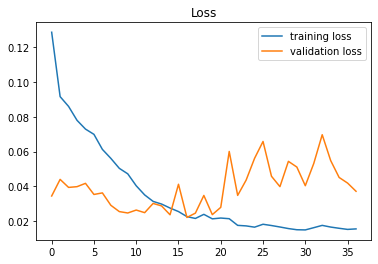

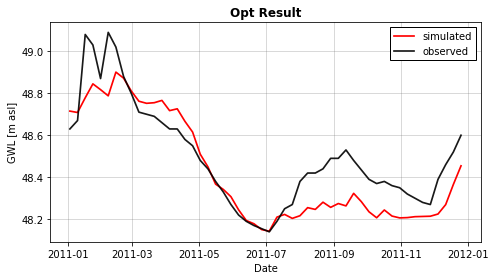

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100


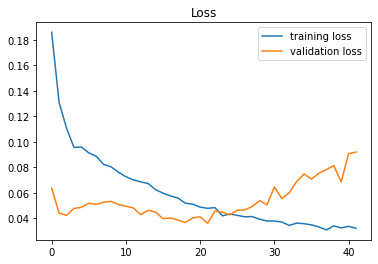

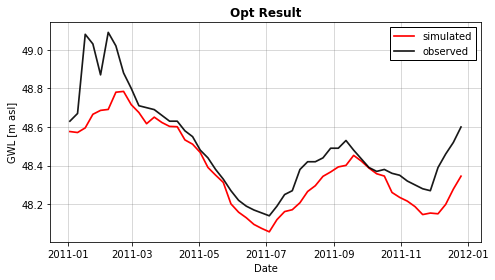

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100


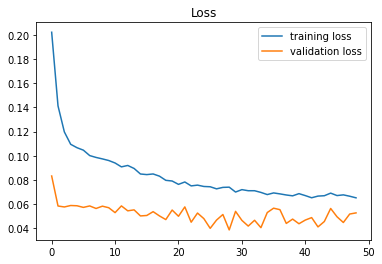

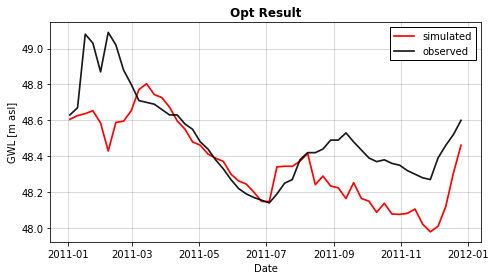

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100


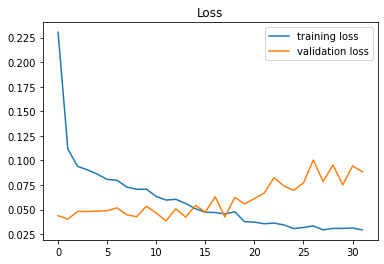

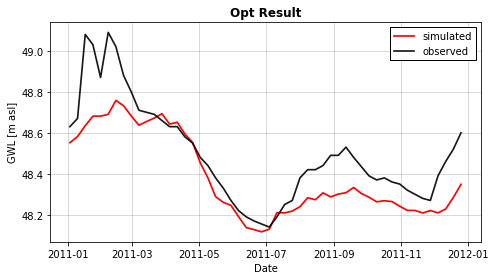

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100


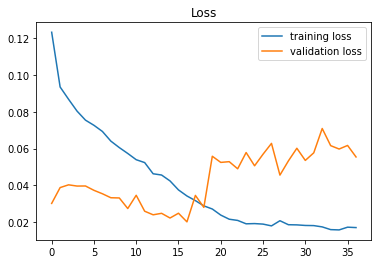

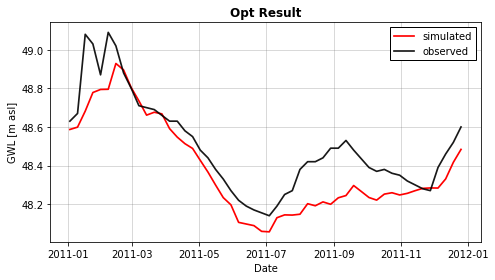

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100


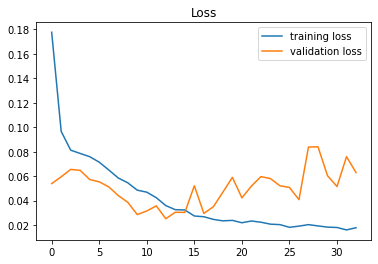

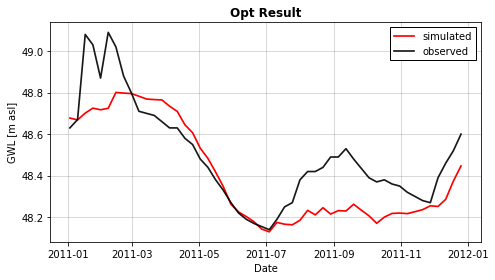

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100


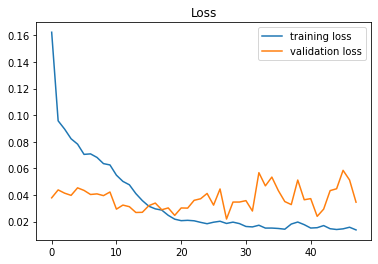

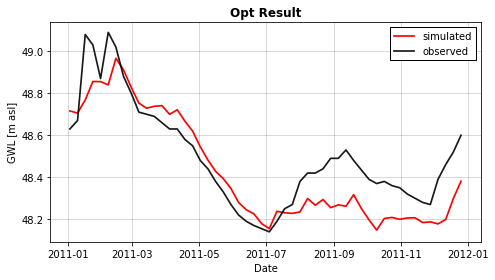

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100


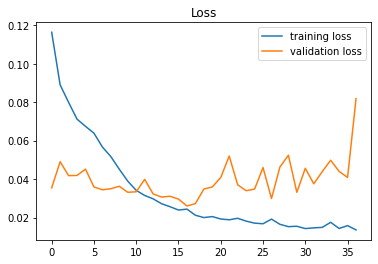

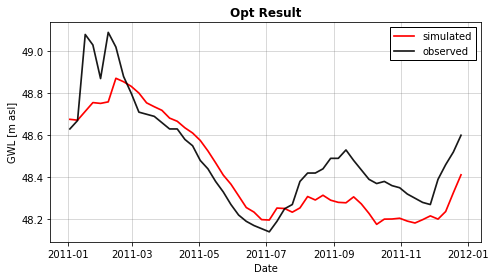

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100


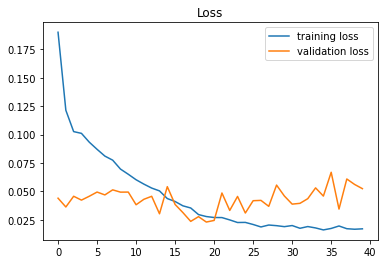

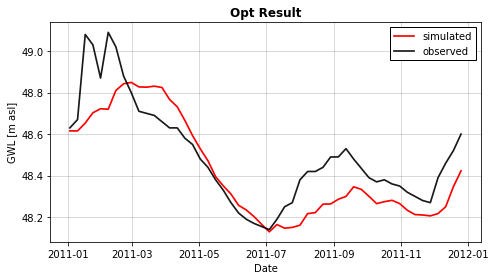

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100


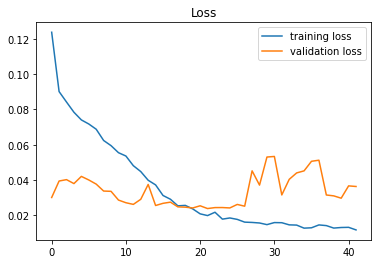

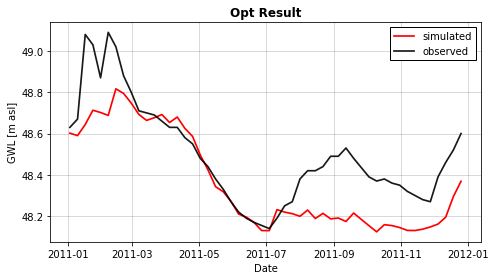

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


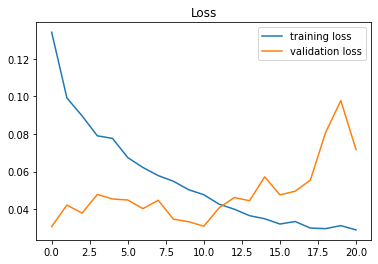

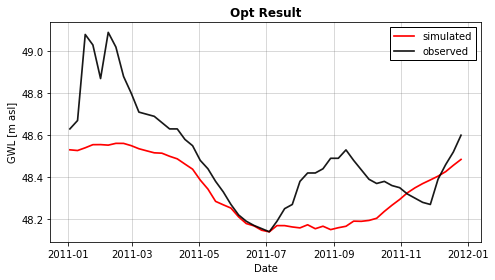

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100


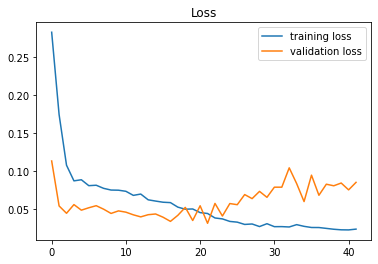

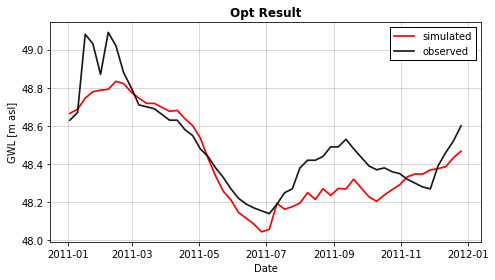

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100


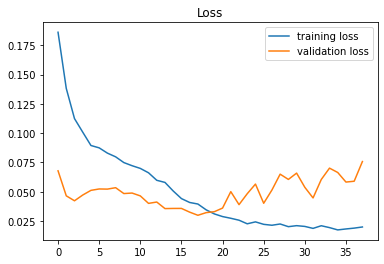

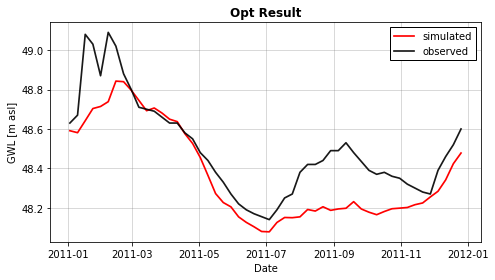

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100


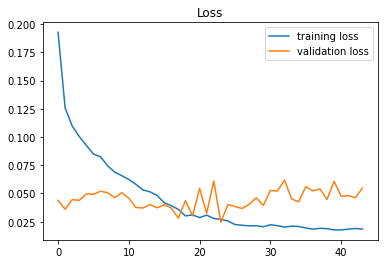

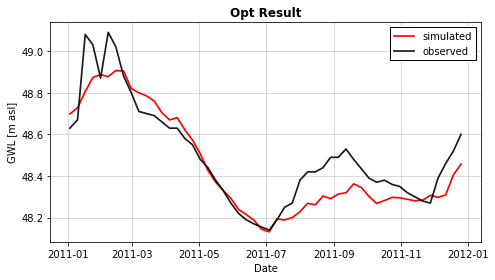

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100


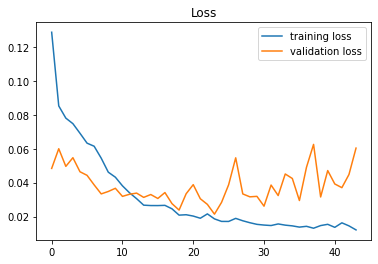

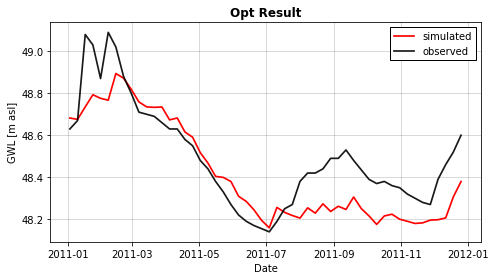

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100


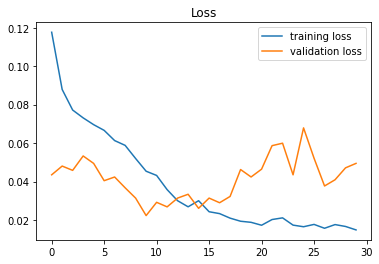

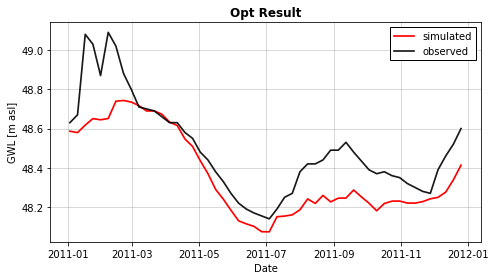

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100


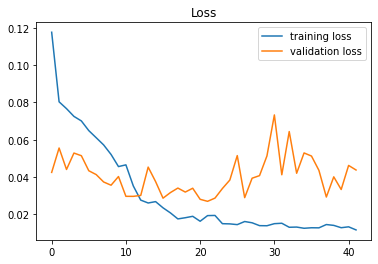

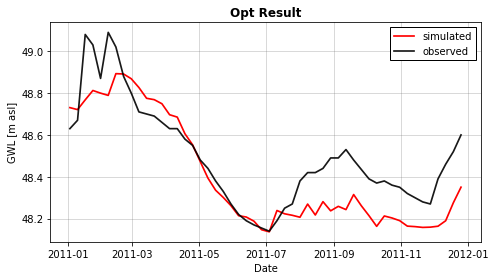

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100


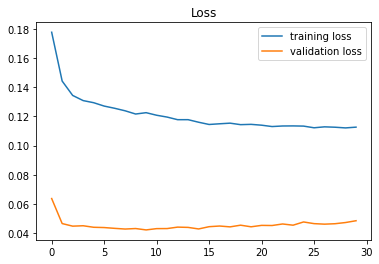

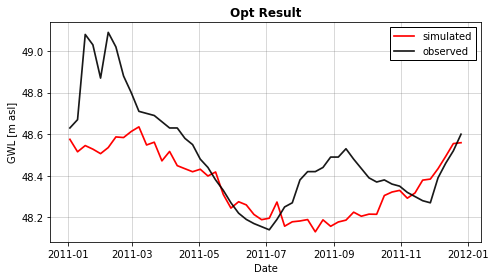

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100


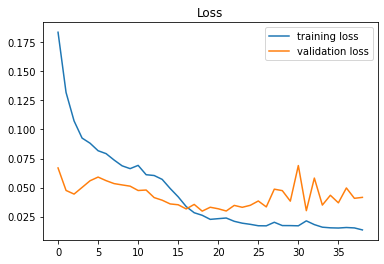

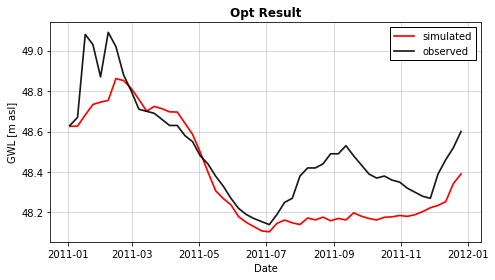

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100


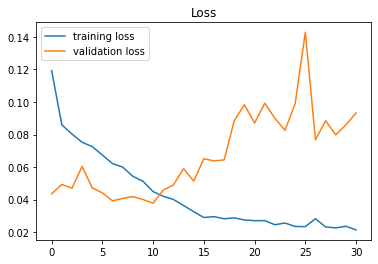

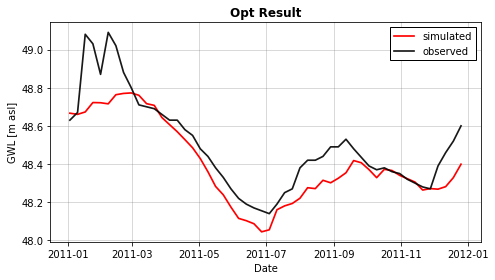

In [41]:
#Zunächst laden wir das BayesianOptimization Package:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

#nun legen wir fest welche HP optimiert werden sollen und in welchen Bereichen (parameter bounds):

pbounds = {'n_steps_in': (1,50), #fast bis zu ein Jahr (52 Wochen), knapp darunter, weil wir sonst die Überlappung der Datensätze anders coden müssten, da unser Stopset nur 1 Jahr lang ist.
           'n': (10,50)} 

# # für mehrere HPs:
# pbounds = {'X': (Min,Max),
#            'Y': (Min,Max)
#           } #etc...


#Hier definieren wir den eigentlichen Optimizer
optimizer = BayesianOptimization(
    f= bayesoptfunction, #Funktion die optimiert wird (s.o. die Funktion die wir geschrieben haben)
    pbounds=pbounds, #Wertebereiche in denen optimiert wird
    random_state=1, #seed
    verbose = 0 # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent, verbose = 2 prints everything
    )

# Save progress: der logger schreibt die Ergbenisse der Iteration in einem json file mit:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

#Start der Optimierung
optimizer.maximize(
        init_points=5, #steps of random exploration (random starting points)
        n_iter=15, # steps of bayesian optimization
        acq="ei",# ei  = expected improvmenet (probably the most common acquisition function) 
        xi=0.05  #  Prefer exploitation (xi=0.0) / Prefer exploration (xi=0.1)
        )

#Nach abgeschlossener Optimierung wollen wir den besten Wert für n_steps_in auslesen:    
#get best values from optimizer

n_steps_in= int(optimizer.max.get("params").get("n_steps_in")) # auch hier wollen wir wieder den integer haben
n = int(optimizer.max.get("params").get("n"))



In [42]:
#beste Iteration anzeigen:
print("\nBEST:\t{}".format(optimizer.max))

#Nachschauen nach welcher Iteration bereits das Maximum erreicht wurde:
beststep = False
step = -1
while not beststep:
    step = step + 1
    beststep = optimizer.res[step] == optimizer.max
print("\nbest step {:.0f} of {:.0f} steps in total".format(step+1, len(optimizer.res)))


BEST:	{'target': -0.010300838377209076, 'params': {'n': 18.816028777923805, 'n_steps_in': 25.951020641690132}}

best step 14 of 20 steps in total


Lasst uns nun das Modell mit den gefundenen n_steps_in trainieren und auf die Testdaten anwenden (gleicher Code wie in der Funktion oben, nur Testdaten statt Optdaten):

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100


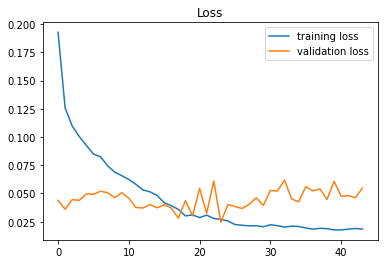

In [43]:
# extend with overlap to be able to fill sequence later                                              
StopData_ext = pd.concat([TrainingData.iloc[-n_steps_in:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
# OptData_ext = pd.concat([StopData.iloc[-n_steps_in:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
TestData_ext = pd.concat([OptData.iloc[-n_steps_in:], TestData], axis=0) #takes last steps of OptData and combines it with TestData

#create scalers and scale (normalize: *_n) data:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(TrainingData)

scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
scaler_gwl.fit(pd.DataFrame(TrainingData['GWL']))

TrainingData_n = scaler.transform(TrainingData)
StopData_ext_n = scaler.transform(StopData_ext)
TestData_ext_n = scaler.transform(TestData_ext)

#Daten in Sequenzen umwandeln:
X_train,Y_train = make_sequences(np.asarray(TrainingData_n), n_steps_in)
X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), n_steps_in)
X_test,Y_test = make_sequences(np.asarray(TestData_ext_n), n_steps_in)

#Model bauen und trainieren:

#set seed
ini=0
seed(ini+872527)
tf.random.set_seed(ini+87747)

#build model
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))#Define Input Shape
lstm = tf.keras.layers.LSTM(n)(inp)#add LSTM Layer
lstm = tf.keras.layers.Dropout(0.1)(lstm)
lstm = tf.keras.layers.Dense(30, activation='relu')(lstm)#add a dense layer
output1 = tf.keras.layers.Dense(1, activation='linear')(lstm) # output neuron to get meaningful output values
model = tf.keras.Model(inputs=inp, outputs=output1)#tie together

#define optimizer
adamoptimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

#compile the model
model.compile(loss='mse', optimizer=adamoptimizer, metrics=['mse'])

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()


#Modell testen mit X_test
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

Nun berechnen wir wieder Fehlerwerte und Plotten das Ergebnis:

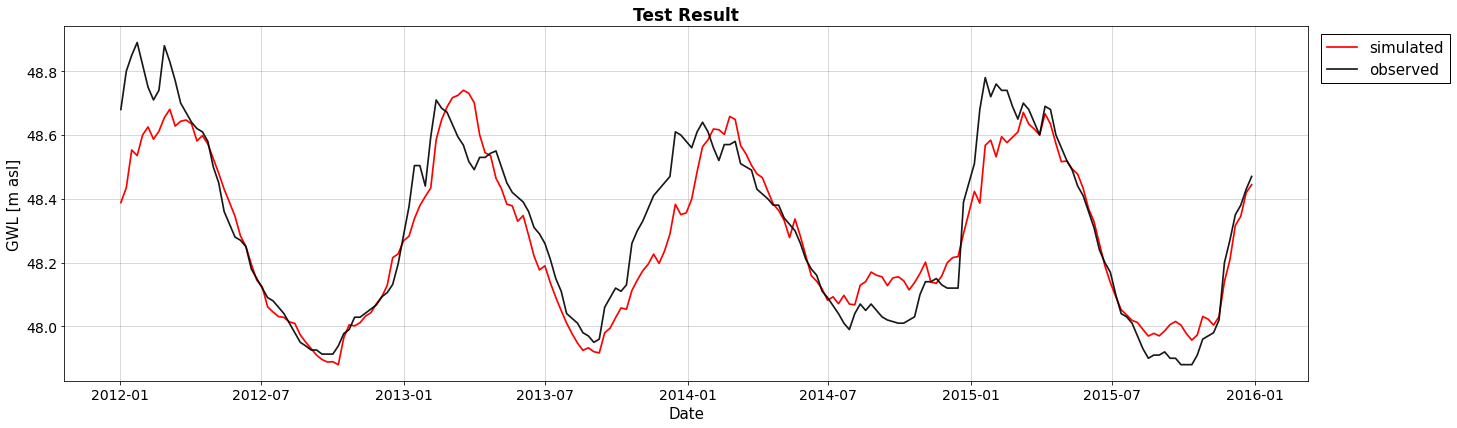

In [44]:
from scipy import stats

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [45]:
print("n_steps_in = {:.0f} weeks".format(n_steps_in))
print("n = {:.0f} units".format(n))
scores.head()

n_steps_in = 25 weeks
n = 18 units


,NSE,RMSE,r,Bias
0,0.866056,0.101095,0.936598,-0.023059


### Aufgabe 1: zusätzlichen Hyperparameter optimieren

Wir möchten neben n_steps_in nun auch die Anzahl der LSTm units im LSTM Layer optimieren. Wir nennen dieses Parameter *n*

Ändere den obigen Code so, dass beide Parameter optimiert werden. nutze dafür folende Anleitung:  
* Füge *n* der Funktion bayesopt als Input parameter hinzu (gnau wie n_steps_in)
* Wandle *n* zu Beginn der Funktion in einen integer um (genau wie n_steps_in)
* Füge *n* an entsprechener Stelle im LSTM Layer ein
* Optimiere *n* für einen Wertebereich von 10 bis 50 (Parameter dem pbounds Dict hinzufügen)
* Entnehme den besten Wert für n dem optimizer mit folgendem Befehl: *n = int(optimizer.max.get("params").get("n"))* 
* Ändere *n* auch im Code für das Model, welches für die Testdaten verwendet wird

## Ensembles

Wir möchten die Abhängigkeit vom Random Seed verringern. Schreibe die folgende Notebook-zelle als Schleife bei der der Parameter *ini* von 0 bis 4 (also 5 verschiedene Werte: 0,1,2,3,4) varriert wird. Vergiss dafür nicht alle Zeilen nach dem Einrichten der Schleife einzurücken. 

ini 0


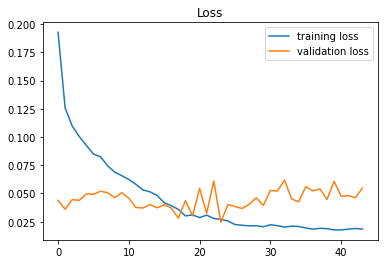

ini 1


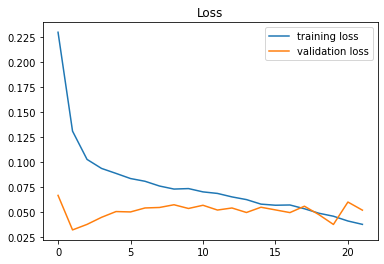

ini 2


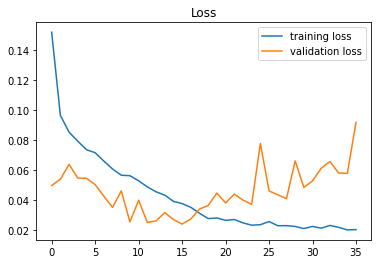

ini 3


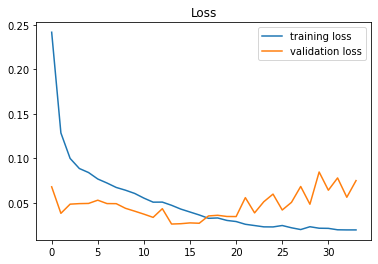

ini 4


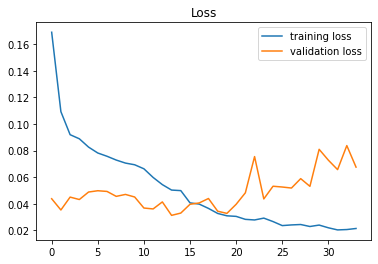

In [46]:
sim = np.zeros((Y_test.shape[0],5)) #das nennt man preallocation, 
#weiter unten im Code soll nachdem die Schleife eingefügt wurde bei jedem Durchgang 
#das Ergebnis folgendermaßen abegelegt werden: sim[:,ini] = [...]

#Model bauen und trainieren:

#set seed

# ini=0 # Hier sollte die Schleife beginnen (statt ini=0)


for ini in range(5):
    seed(ini+872527)
    tf.random.set_seed(ini+87747)
    print("ini {}".format(ini))

    #build model
    inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))#Define Input Shape
    lstm = tf.keras.layers.LSTM(n)(inp)#add LSTM Layer
    lstm = tf.keras.layers.Dropout(0.1)(lstm)
    lstm = tf.keras.layers.Dense(30, activation='relu')(lstm)#add a dense layer
    output1 = tf.keras.layers.Dense(1, activation='linear')(lstm) # output neuron to get meaningful output values
    model = tf.keras.Model(inputs=inp, outputs=output1)#tie together

    #define optimizer
    adamoptimizer = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

    #compile the model
    model.compile(loss='mse', optimizer=adamoptimizer, metrics=['mse'])

    #define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

    #train the model
    history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=0,
                        batch_size=32, callbacks=[es])

    #plot training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.title('Loss')
    plt.show()


    #Modell testen mit X_test
    sim_temp = model.predict(X_test)

    #rescale simulated and observed values
    sim[:,ini] = scaler_gwl.inverse_transform(sim_temp).reshape(-1,)  # retransform to original scale
    obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

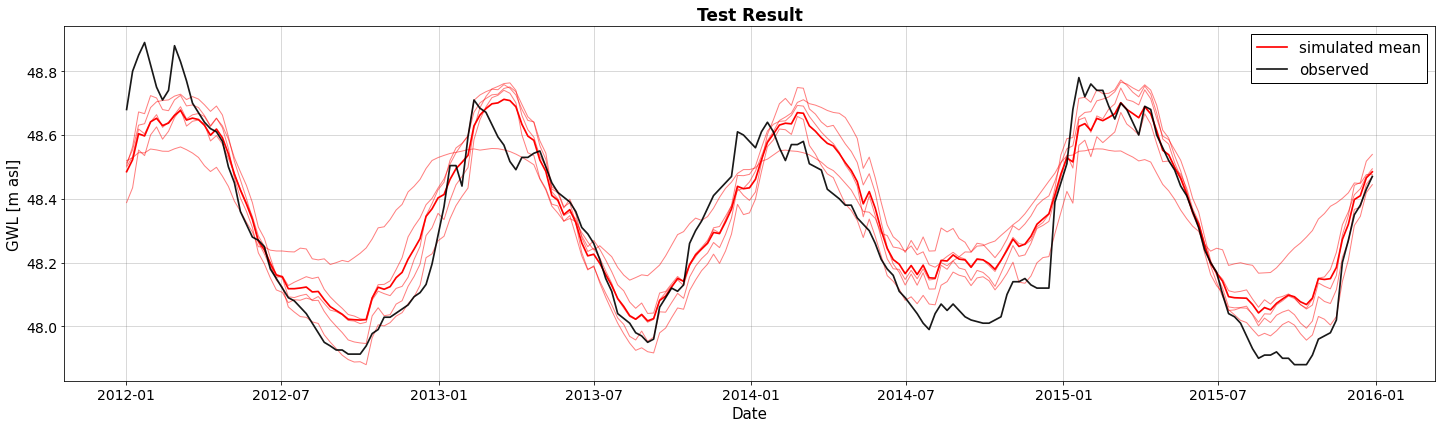

,NSE,RMSE,r,Bias
0,0.832864,0.112928,0.940044,0.044548


In [47]:
sim_mean = np.mean(sim,axis = 1).reshape(-1,1) #wir berechnen die Fheler für den Mittelwert des Ensembles

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim_mean-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim_mean-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim_mean[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim_mean-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))

for i in range(5):
    plt.plot(TestData.index, sim[:,i], 'r', label = None, linewidth = 1, alpha = 0.5)

plt.plot(TestData.index, sim_mean, 'r', label ="simulated mean", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(b=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

scores.head()

In diesem Fall wird die Performance des Ensemble Mittelwertes sogar etwas schlechter, wir erhalten aber trotzdem eien robusteren Schätzwert des Ergebnisses. Die gute Performance für ini = 0 von oben, war im Grunde Zufall.